# Covid-19 Auto-Detection using Deep Learning - Rohit Bhalerao ( November 2021 )

## Variation # 07: 

1. Class Imbalance : No ( Number of Covid images : 1500 , Number of Non-Covid images : 1500 )

2. Image Augmentation : Yes

3. Noise Removal from images : No







**Connect to Google Drive to access Dataset**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/COVID_Detection'

Mounted at /content/drive
/content/drive/My Drive/COVID_Detection


**Import all dependencies**

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import EfficientNetB7

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import cv2 
from skimage import transform as tf

**Define Few Parameters**

In [ ]:
#define parameters
IMAGE_SIZE = [224, 224]
epochs = 30
batch_size = 32
covid_path = 'data/COVID'
noncovid_path = 'data/NORMAL'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

count_orig_covid_img_for_model = 1500
count_normal_img_for_model = 1500

In [ ]:
# Understand the number of images in covid_files folder
len(covid_files)

In [ ]:
# understand the number images in Non Covid files folder
len(noncovid_files)

**Fetch Images and Class Labels from Files (This might take a while)**

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []
covid_images=[]
noncovid_images=[]

# Covid Images
for i in range(count_orig_covid_img_for_model):
  #if i%10==0:
   # print('i:',i)
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('COVID')


# Normal Images
for j in range(count_normal_img_for_model): 
  #if j%10==0:
  #  print('j:',j)
  image = cv2.imread(noncovid_files[j])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('NonCOVID')

Visualize First 40 Images from Data set

In [ ]:
# look at few images
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

In [ ]:
#plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
#plot_images(gauss_noise_removed_images, 'Gaussian Noise Removed : Positive COVID-19 Chest X-ray')
#plot_images(median_noise_removed_images, 'Median Noise Removed : Positive COVID-19 Chest X-ray')
#plot_images(left_shear_images, 'Left Shear Images : Positive COVID-19 Chest X-ray')
#plot_images(right_shear_images, 'Right Shear Images : Positive COVID-19 Chest X-ray')
#plot_images(anticlock_rot_images, 'Anticlock Rotated Images : Positive COVID-19 Chest X-ray')
#plot_images(clock_rot_images, 'clock Rotated Images : Positive COVID-19 Chest X-ray')
#plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

**Normalization**

Model takes images in the form of array of pixels. Hence convert into array and normalize

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

# Normalizing image inputs: Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. 
# This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. 
# The distribution of such data would resemble a Gaussian curve centered at zero. 
# For image inputs we need the pixel numbers to be positive, so we might choose to scale the normalized data in the range [0,1] or [0, 255].
# https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258


Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

**Visualize a few images from Training and Test sets**

In [ ]:
# plot_images(covid_x_train, 'X_train')

In [ ]:
# plot_images(covid_x_test, 'X_test')

# Variation # 7
# Model #1 : Xception
## Experiment #31

In [ ]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

**Images Augmentation**

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

# ImageDataGenerator class has the argument height_shift_range for a vertical shift of image and width_shift_range for a horizontal shift of image. 
# If the value is a float number, that would indicate the percentage of width or height of the image to shift. 
# Otherwise, if it is an integer value then simply the width or height are shifted by those many pixel values.

# ImageDataGenerator class allows you to randomly rotate images through any degree between 0 and 360 by providing an integer value in the rotation_range argument.
# When the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in. 
# You can fill this in different ways like a constant value or nearest pixel values, etc. 
# This is specified in the fill_mode argument and the default value is “nearest” which simply replaces the empty area with the nearest pixel values.

# Apply Augmentation to the images

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)



**Training the model**

In [ ]:
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-31-Xception-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.1559 - accuracy: 0.8208
Epoch 00001: val_accuracy improved from -inf to 0.79167, saving model to Experiment-31-Xception-model-epoch-01-val-accuracy:-0.7917.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


75/75 [==============================] - 35s 336ms/step - loss: 1.1559 - accuracy: 0.8208 - val_loss: 1.6453 - val_accuracy: 0.7917
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.8575
Epoch 00002: val_accuracy improved from 0.79167 to 0.84167, saving model to Experiment-31-Xception-model-epoch-02-val-accuracy:-0.8417.h5
75/75 [==============================] - 24s 322ms/step - loss: 0.8547 - accuracy: 0.8575 - val_loss: 1.0395 - val_accuracy: 0.8417
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.8833
Epoch 00003: val_accuracy improved from 0.84167 to 0.86500, saving model to Experiment-31-Xception-model-epoch-03-val-accuracy:-0.8650.h5
75/75 [==============================] - 24s 317ms/step - loss: 0.6410 - accuracy: 0.8833 - val_loss: 0.7298 - val_accuracy: 0.8650
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.8933
Epoch 00004: val_accuracy improved from 0.8650

In [ ]:
# Load best model for making prediction and plotting the statistics

model = load_model('Experiment-31-Xception-model-epoch-22-val-accuracy:-0.9250.h5')

** Making and Visulaizing First 10 predictions**


In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
    plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
    plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

Convert to Binary classes

In [ ]:
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

**Plot ROC Curve, Confusion Matrix, Classification Report, Accuracy and Loss Plots **

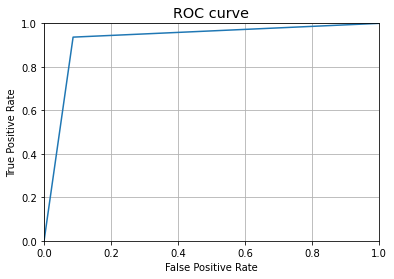

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

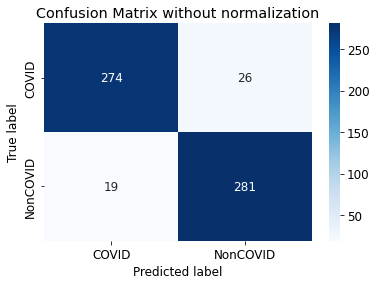

----------------------------------------------


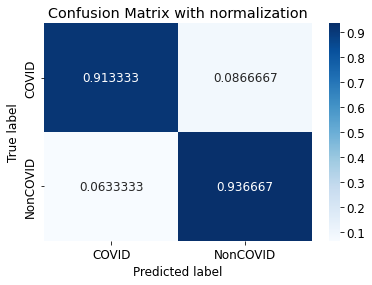

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       300
           1       0.92      0.94      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.92       600
weighted avg       0.93      0.93      0.92       600



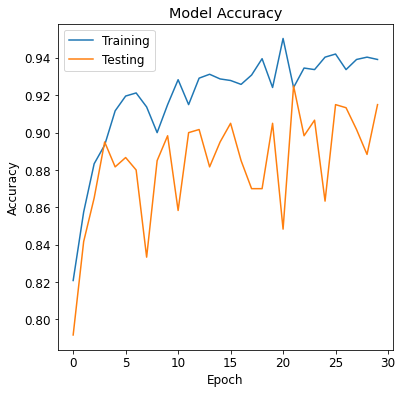

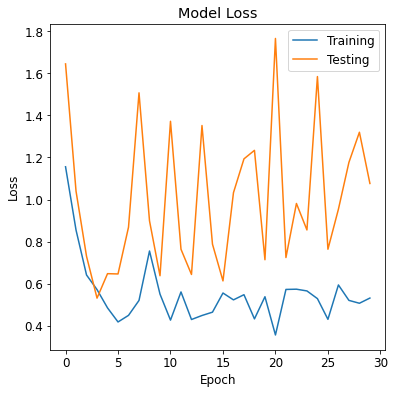

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
#plt.savefig('Experiment_09_xception_accuracy.png')
plt.show()
plt.figure(figsize=(6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'])
#plt.savefig('Experiment_09_xception_loss.png')
plt.show()

## Variation #7
## Model #2 : InceptionV3
## Experiment #32

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)              

In [ ]:
# Apply Augmentation to the images

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

### Training the model

In [ ]:
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-32-Inception-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.7477 - accuracy: 0.7875
Epoch 00001: val_accuracy improved from -inf to 0.70000, saving model to Experiment-32-Inception-model-epoch-01-val-accuracy:-0.7000.h5
75/75 [==============================] - 29s 334ms/step - loss: 1.7477 - accuracy: 0.7875 - val_loss: 3.8000 - val_accuracy: 0.7000
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 1.1951 - accuracy: 0.8487
Epoch 00002: val_accuracy improved from 0.70000 to 0.81000, saving model to Experiment-32-Inception-model-epoch-02-val-accuracy:-0.8100.h5
75/75 [==============================] - 23s 311ms/step - loss: 1.1951 - accuracy: 0.8487 - val_loss: 1.7554 - val_accuracy: 0.8100
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.8800
Epoch 00003: val_accuracy improved from 0.81000 to 0.81833, saving model to Experiment-32-Inception-model-epoch-03-val-accuracy:-0.8183.h5
75/75 [==============================] -

In [ ]:
# Load best model for making prediction and plotting the statistics
# Edit the model name

model = load_model('Experiment-32-Inception-model-epoch-28-val-accuracy:-0.9150.h5')

### Making the predictions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

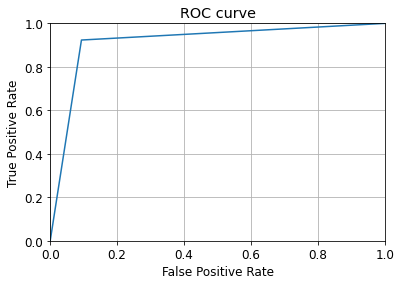

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

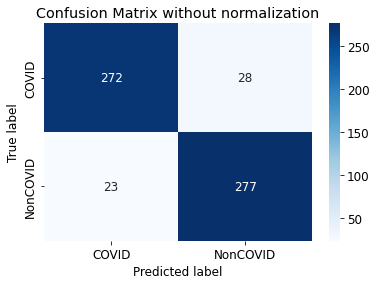

----------------------------------------------


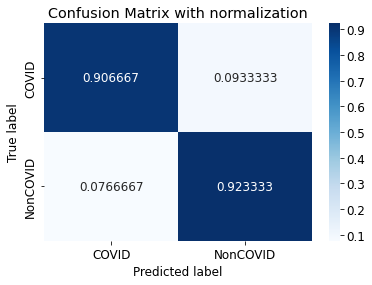

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       300
           1       0.91      0.92      0.92       300

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.91       600
weighted avg       0.92      0.92      0.91       600



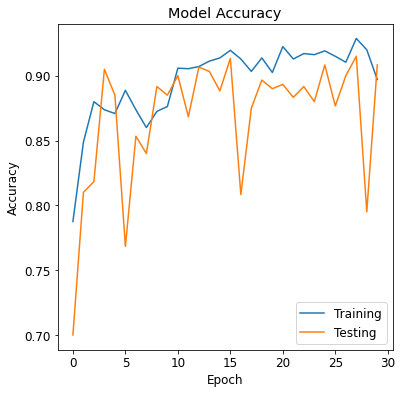

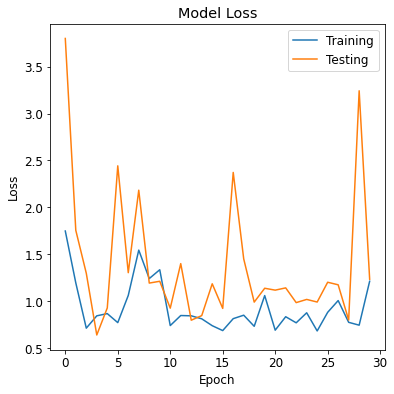

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

## Variation #7
## Model #3 : VGG19
## Experiment #33



In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

80150528/80134624 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Apply Augmentation to the images

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

### Training the model

In [ ]:
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-33-VGG19-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7812
Epoch 00001: val_accuracy improved from -inf to 0.87000, saving model to Experiment-33-VGG19-model-epoch-01-val-accuracy:-0.8700.h5
75/75 [==============================] - 30s 349ms/step - loss: 0.5836 - accuracy: 0.7812 - val_loss: 0.2798 - val_accuracy: 0.8700
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8662
Epoch 00002: val_accuracy improved from 0.87000 to 0.88167, saving model to Experiment-33-VGG19-model-epoch-02-val-accuracy:-0.8817.h5
75/75 [==============================] - 23s 311ms/step - loss: 0.3204 - accuracy: 0.8662 - val_loss: 0.2952 - val_accuracy: 0.8817
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8763
Epoch 00003: val_accuracy improved from 0.88167 to 0.89167, saving model to Experiment-33-VGG19-model-epoch-03-val-accuracy:-0.8917.h5
75/75 [==============================] - 24s 321ms/s

In [ ]:
# Load best model for making prediction and plotting the statistics
# Edit the model name

model = load_model('Experiment-33-VGG19-model-epoch-20-val-accuracy:-0.9500.h5')

### Making the predictions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot statistics

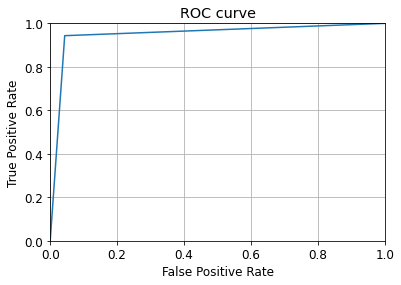

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

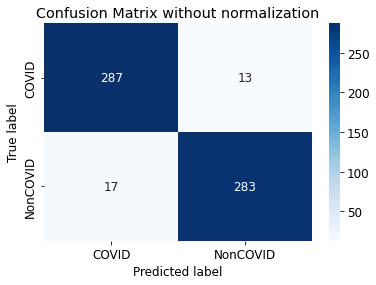

----------------------------------------------


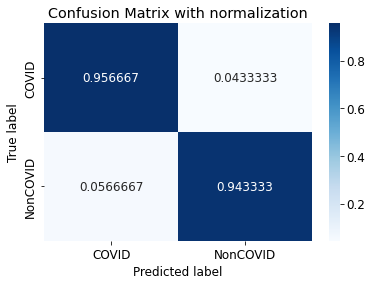

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       300
           1       0.96      0.94      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



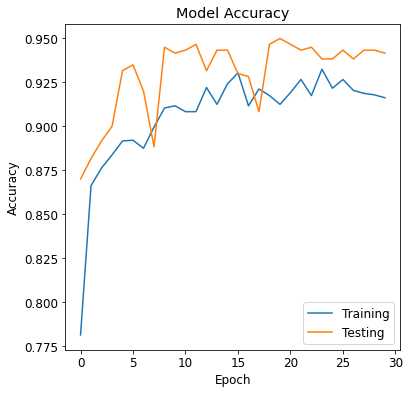

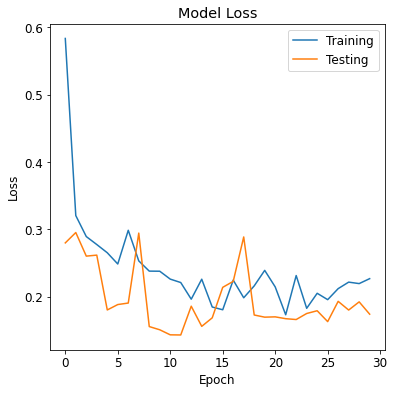

In [ ]:


def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

## Variation #7 
## Model #4 : ResNet
## Experiment #34

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# Apply Augmentation to the images

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

### Training the Model

In [ ]:
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-34-ResNet-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.1866 - accuracy: 0.6192
Epoch 00001: val_accuracy improved from -inf to 0.77000, saving model to Experiment-34-ResNet-model-epoch-01-val-accuracy:-0.7700.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


75/75 [==============================] - 27s 325ms/step - loss: 1.1866 - accuracy: 0.6192 - val_loss: 0.5356 - val_accuracy: 0.7700
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.7212 - accuracy: 0.7079
Epoch 00002: val_accuracy did not improve from 0.77000
75/75 [==============================] - 23s 303ms/step - loss: 0.7212 - accuracy: 0.7079 - val_loss: 0.7112 - val_accuracy: 0.6983
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7188
Epoch 00003: val_accuracy improved from 0.77000 to 0.77667, saving model to Experiment-34-ResNet-model-epoch-03-val-accuracy:-0.7767.h5
75/75 [==============================] - 23s 309ms/step - loss: 0.7265 - accuracy: 0.7188 - val_loss: 0.5572 - val_accuracy: 0.7767
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 0.6781 - accuracy: 0.7312
Epoch 00004: val_accuracy did not improve from 0.77667
75/75 [==============================] - 23s 302ms/step - loss: 0.6781 - acc

In [ ]:
# Load best model for making prediction and plotting the statistics
# Edit the model name

model = load_model('Experiment-34-ResNet-model-epoch-29-val-accuracy:-0.8183.h5')

### Making the Predictions

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

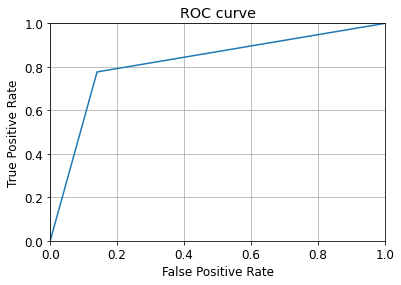

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

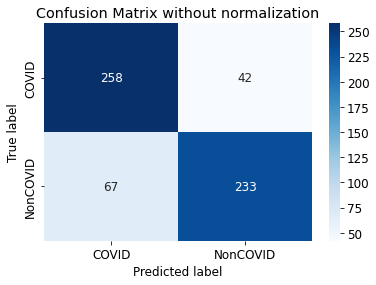

----------------------------------------------


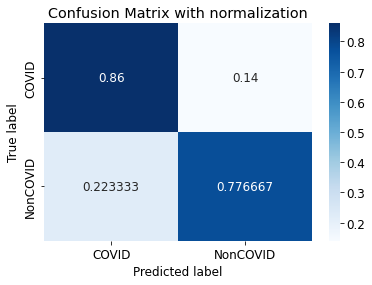

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       300
           1       0.85      0.78      0.81       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600



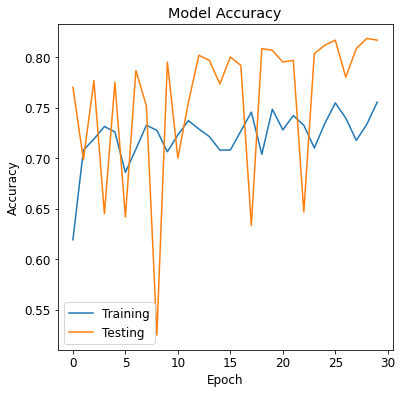

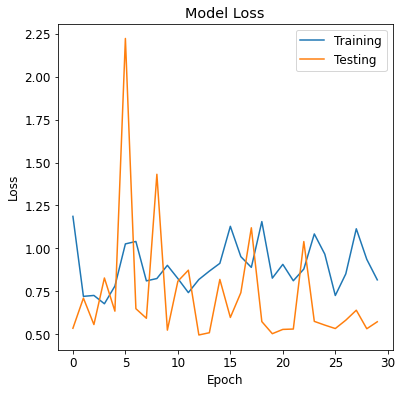

In [ ]:


def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

## Variation # 08: 

1. Class Imbalance : No ( Number of Covid images : 1500 , Number of Non-Covid images : 1500 )

2. Image Augmentation : Yes

3. Noise Removal from images : Yes

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

count_orig_covid_img_for_model = 1500
count_normal_img_for_model = 1500


In [ ]:
for i in range(count_orig_covid_img_for_model):
  #if i%10==0:
  #  print('i:',i)
  image = cv2.imread(covid_files[i])
  image = cv2.GaussianBlur(image, (9, 9),0) # Remove Gaussian Noise
  image = cv2.medianBlur(image, 9) # Remove Median Noise
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('COVID')

  # Normal Images
for j in range(count_normal_img_for_model): 
  #if j%10==0:
  #  print('j:',j)
  image = cv2.imread(noncovid_files[j])
  image = cv2.GaussianBlur(image, (9, 9),0) # Remove Gaussian Noise
  image = cv2.medianBlur(image, 9) # Remove Median Noise
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('NonCOVID')

In [ ]:
# Plot Images
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

In [ ]:
# Normalization
# Model takes images in the form of array of pixels. Hence convert into array and normalize
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [ ]:
# split into training and testing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

## Variation #8 
## Model #1 : Xception
## Experiment #36

In [ ]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
# Adjust the parameters of image augmentation 

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [ ]:
### Training the model
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-36-Xception-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)


Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.3182 - accuracy: 0.7862
Epoch 00001: val_accuracy improved from -inf to 0.87167, saving model to Experiment-36-Xception-model-epoch-01-val-accuracy:-0.8717.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


75/75 [==============================] - 35s 328ms/step - loss: 1.3182 - accuracy: 0.7862 - val_loss: 0.4556 - val_accuracy: 0.8717
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.8779
Epoch 00002: val_accuracy improved from 0.87167 to 0.88333, saving model to Experiment-36-Xception-model-epoch-02-val-accuracy:-0.8833.h5
75/75 [==============================] - 24s 314ms/step - loss: 0.4926 - accuracy: 0.8779 - val_loss: 0.4634 - val_accuracy: 0.8833
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.8750
Epoch 00003: val_accuracy did not improve from 0.88333
75/75 [==============================] - 23s 309ms/step - loss: 0.5453 - accuracy: 0.8750 - val_loss: 1.3680 - val_accuracy: 0.8250
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.8821
Epoch 00004: val_accuracy did not improve from 0.88333
75/75 [==============================] - 23s 306ms/step - loss: 0.5074 - a

In [ ]:
### Load best model for making prediction and plotting the statistics
model = load_model('Experiment-36-Xception-model-epoch-16-val-accuracy:-0.9233.h5')

# Make Predictions
y_pred = model.predict(X_test, batch_size=batch_size)

# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

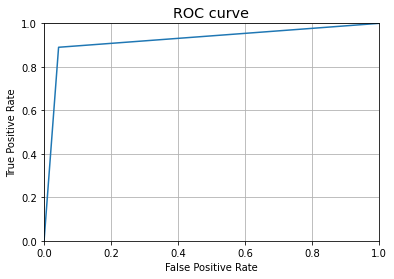

In [ ]:
# Plot Statistics
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

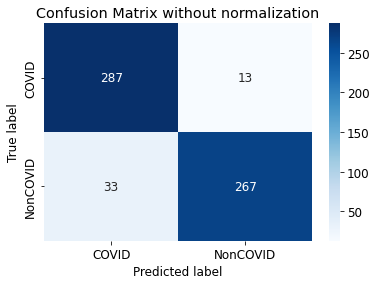

----------------------------------------------


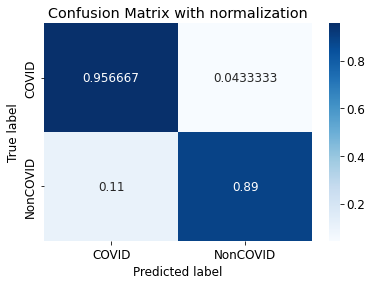

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       300
           1       0.95      0.89      0.92       300

    accuracy                           0.92       600
   macro avg       0.93      0.92      0.92       600
weighted avg       0.93      0.92      0.92       600



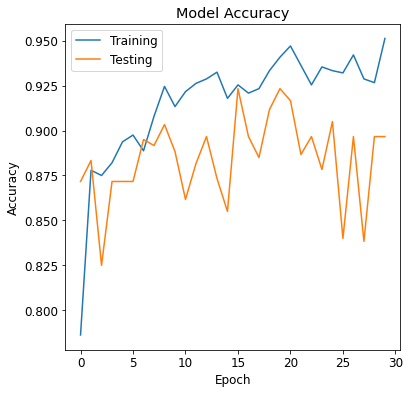

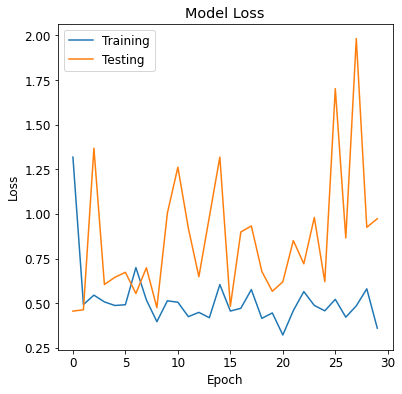

In [ ]:


def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

# Accuracy and Loss Plots
plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()


plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()


## Variation #8 
## Model #2 : InceptionV3
## Experiment #37

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)              

In [ ]:
# Adjust the parameters of image augmentation 

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
# Train the model
from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-37-Inception-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 2.2979 - accuracy: 0.7821
Epoch 00001: val_accuracy improved from -inf to 0.78500, saving model to Experiment-37-Inception-model-epoch-01-val-accuracy:-0.7850.h5
75/75 [==============================] - 28s 330ms/step - loss: 2.2979 - accuracy: 0.7821 - val_loss: 1.4889 - val_accuracy: 0.7850
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.8550
Epoch 00002: val_accuracy improved from 0.78500 to 0.84167, saving model to Experiment-37-Inception-model-epoch-02-val-accuracy:-0.8417.h5
75/75 [==============================] - 23s 308ms/step - loss: 0.8500 - accuracy: 0.8550 - val_loss: 0.9315 - val_accuracy: 0.8417
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.7540 - accuracy: 0.8633
Epoch 00003: val_accuracy improved from 0.84167 to 0.90667, saving model to Experiment-37-Inception-model-epoch-03-val-accuracy:-0.9067.h5
75/75 [==============================] -

In [ ]:
# Load best model for making prediction and plotting the statistics
# Edit the model name

model = load_model('Experiment-37-Inception-model-epoch-24-val-accuracy:-0.9400.h5')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

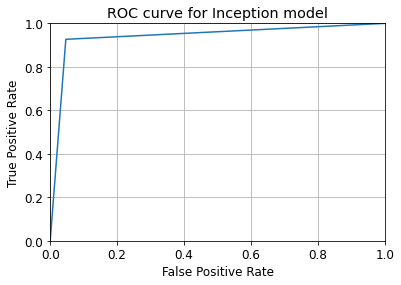

In [ ]:
# Plot statistics

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Inception model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


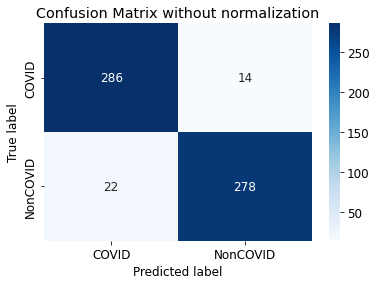

----------------------------------------------
Confusion Matrix with Normalized Values


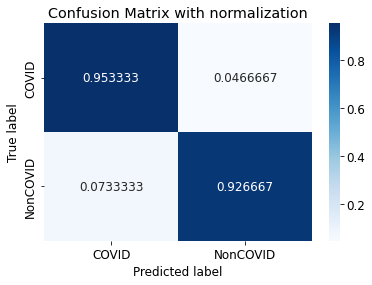

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       300
           1       0.95      0.93      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



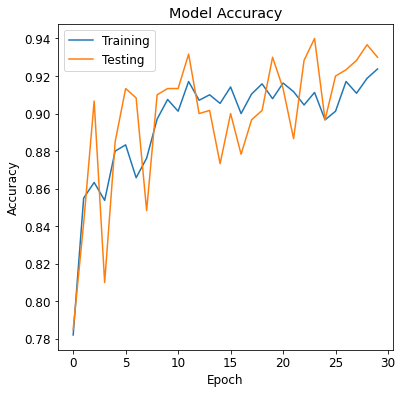

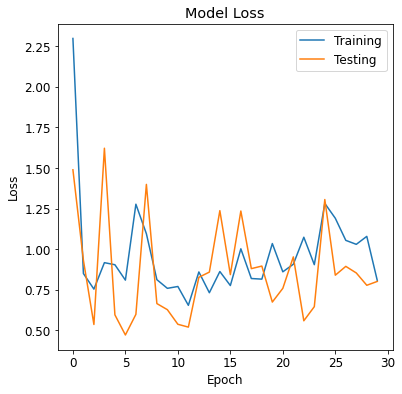

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

### Accuracy and Loss Plots
plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()


In [ ]:
# Model with 60 epochs

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=60)

Epoch 1/60
75/75 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.9250
Epoch 00001: val_accuracy did not improve from 0.94000
75/75 [==============================] - 26s 326ms/step - loss: 0.7408 - accuracy: 0.9250 - val_loss: 0.6369 - val_accuracy: 0.9300
Epoch 2/60
75/75 [==============================] - ETA: 0s - loss: 1.0505 - accuracy: 0.9083
Epoch 00002: val_accuracy improved from 0.94000 to 0.94333, saving model to Experiment-37-Inception-model-epoch-02-val-accuracy:-0.9433.h5
75/75 [==============================] - 23s 308ms/step - loss: 1.0505 - accuracy: 0.9083 - val_loss: 0.5735 - val_accuracy: 0.9433
Epoch 3/60
75/75 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.9079
Epoch 00003: val_accuracy did not improve from 0.94333
75/75 [==============================] - 23s 300ms/step - loss: 1.0018 - accuracy: 0.9079 - val_loss: 1.2382 - val_accuracy: 0.9083
Epoch 4/60
75/75 [==============================] - ETA: 0s - loss: 1.124

## Variation # 8 
## Model #3 : VGG19
## Experiment #38


In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Adjust the parameters of image augmentation 

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

Training the model

In [ ]:
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-38-vgg-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.5719 - accuracy: 0.7387
Epoch 00001: val_accuracy improved from -inf to 0.78167, saving model to Experiment-38-vgg-model-epoch-01-val-accuracy:-0.7817.h5
75/75 [==============================] - 36s 341ms/step - loss: 0.5719 - accuracy: 0.7387 - val_loss: 0.4182 - val_accuracy: 0.7817
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.4257 - accuracy: 0.8083
Epoch 00002: val_accuracy improved from 0.78167 to 0.91000, saving model to Experiment-38-vgg-model-epoch-02-val-accuracy:-0.9100.h5
75/75 [==============================] - 23s 307ms/step - loss: 0.4257 - accuracy: 0.8083 - val_loss: 0.2257 - val_accuracy: 0.9100
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8500
Epoch 00003: val_accuracy did not improve from 0.91000
75/75 [==============================] - 23s 307ms/step - loss: 0.3325 - accuracy: 0.8500 - val_loss: 0.3041 - val_accuracy: 0.8617
Epoc

In [ ]:
#Load best model for making prediction and plotting the statistics
model = load_model('Experiment-38-vgg-model-epoch-30-val-accuracy:-0.9517.h5')

In [ ]:
# Making Predicions

y_pred = model.predict(X_test, batch_size=batch_size)

# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

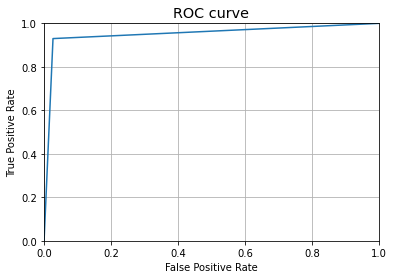

In [ ]:
# Plot ROC Curve

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

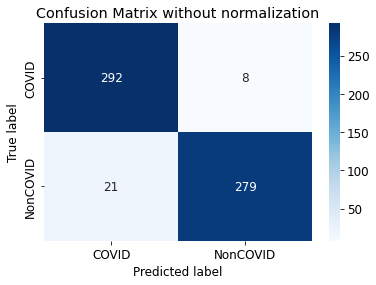

----------------------------------------------


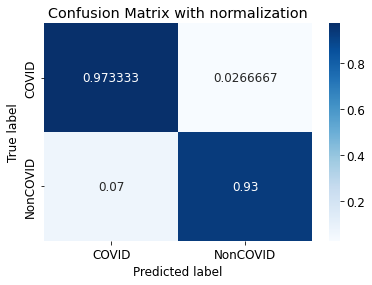

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       300
           1       0.97      0.93      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



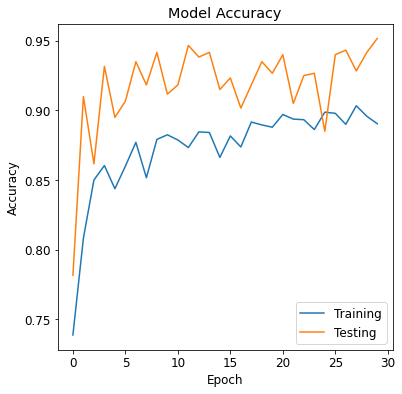

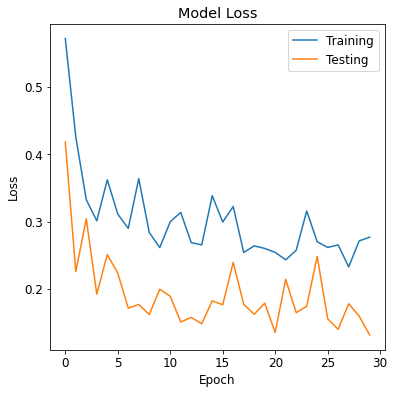

In [ ]:
#Plot Confusion Matrix

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

# Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

## Accuracy and Loss Plots

plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

## Variation #8 
## Model #4 : ResNet
## Experiment #39

In [ ]:
res = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

outputs = res.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=outputs)

for layer in res.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# Adjust the parameters of image augmentation 

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [ ]:
# Training the Model

# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# save the current model ( if better than previous) and go to next epoch and repeat until the end

from keras.callbacks import ModelCheckpoint
# checkpoint
filepath="Experiment-39-ResNet-model-epoch-{epoch:02d}-val-accuracy:-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=callbacks_list,
                    verbose=1,
                    epochs=30)

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 1.4367 - accuracy: 0.5875
Epoch 00001: val_accuracy improved from -inf to 0.74833, saving model to Experiment-39-ResNet-model-epoch-01-val-accuracy:-0.7483.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


75/75 [==============================] - 27s 328ms/step - loss: 1.4367 - accuracy: 0.5875 - val_loss: 0.5357 - val_accuracy: 0.7483
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.6817
Epoch 00002: val_accuracy did not improve from 0.74833
75/75 [==============================] - 23s 305ms/step - loss: 0.7450 - accuracy: 0.6817 - val_loss: 0.9078 - val_accuracy: 0.5133
Epoch 3/30
75/75 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.6833
Epoch 00003: val_accuracy improved from 0.74833 to 0.77167, saving model to Experiment-39-ResNet-model-epoch-03-val-accuracy:-0.7717.h5
75/75 [==============================] - 23s 307ms/step - loss: 0.8335 - accuracy: 0.6833 - val_loss: 0.5001 - val_accuracy: 0.7717
Epoch 4/30
75/75 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.6808
Epoch 00004: val_accuracy improved from 0.77167 to 0.78167, saving model to Experiment-39-ResNet-model-epoch-04-val-accuracy:-0.781

In [ ]:
# Load best model for making prediction and plotting the statistics

model = load_model('Experiment-39-ResNet-model-epoch-19-val-accuracy:-0.8067.h5')

In [ ]:
### Making Predicions

y_pred = model.predict(X_test, batch_size=batch_size)

# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

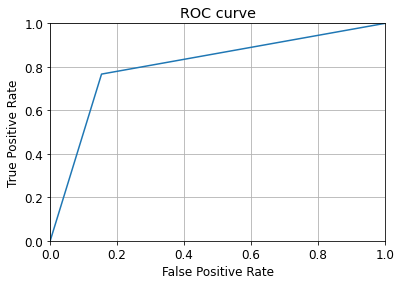

In [ ]:
### Plot ROC Curve

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

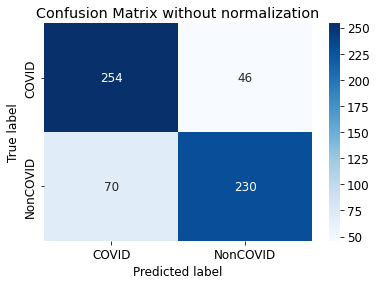

----------------------------------------------


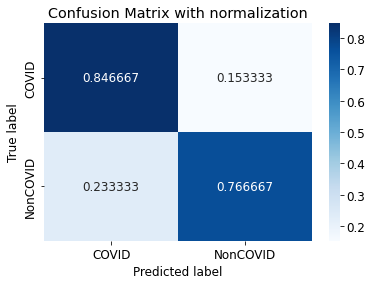

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       300
           1       0.83      0.77      0.80       300

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600



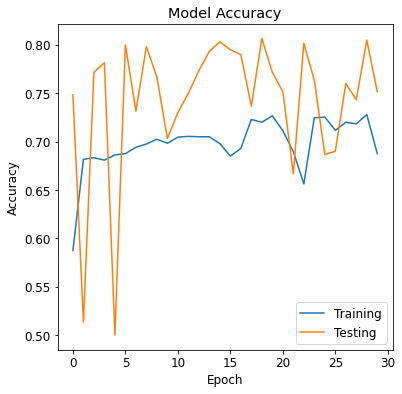

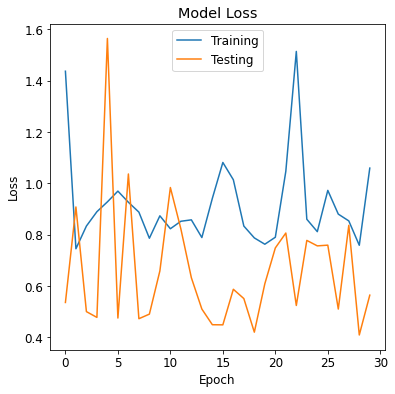

In [ ]:


### Plot Confusion Matrix

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True, fmt='g')
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  if normalize:
    plt.title('Confusion Matrix with normalization')
  else:
    plt.title('Confusion Matrix without normalization')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

plot_confusion_matrix(normalize=None)
print('----------------------------------------------')
plot_confusion_matrix(normalize='true')

# Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

# Accuracy and Loss Plots

plt.figure(figsize=(6,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()

plt.figure(figsize=(6,6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.show()